# **Similar Image Search or Reverse Image Search**

**Aim**

Given a query image, identify the most similar images from a large corpus of images.

**Use-case**

As a user, I want to upload/paste an image from my computer or provide an image link from the web. I want the search functionality to provide images that are similar to the one I provided.

Example services already in use: Google Reverse Image Search / TinEye Reverse Image Search

Model-decision: After going through a few articles on latest pretrained image encoding models and after reading CLIP paper, OpenAI's CLIP model which is trained to deal with both images and language, seemed the best to try. The embedding dimensionality is 512.

Model finalized: openai/clip-vit-base-patch32

**System-architecture and design**

This system requires three pipelines:
1. **Preparation or indexing pipeline**: 

This pipeline is required to ingest a corpus of images, obtain the image represenations and use those to build an n-dimensional index for effective approximate kNN search. To ensure this pipeline works as expected, it is critical to decide upon the right model, a model that is trained such that the cosine/inner product of the image representations translate to similarities between the images

2. **Searching pipeline**: 

This pipeline is required to load the prepared index along with the same image encoding model used for indexing. Upon receiving a query image, this pipeline fetches the representation of the query image and provides this as an n-dimensional datapoint to query the index and get approximate kNearestNeighbors using cosine metric.

3. **Evaluation pipeline**: 

This pipeline is to test and evaluate the prepared search pipeline by providing the images in evaluation dataset and comparing the results obtained vs the gold standard stored in the evaluation dataset.

**Evaluation objective**

For any ML/DL driven solution, it is preferable to first have some initial thoughts on evaluation before starting to work on any solution. 
To have an effective evaluation for a task like similarity search, we need a good gold-standard benchmarking dataset. This dataset should capture diverse set of images specifically aimed by the search functionality. For each of the images in this set, we need context experts to review which images are most applicable from the given corpus. If we plan to consider a very large corpus, it makes it very tough to get this data annotated.

However, an alternative would be to build a baseline image search and employ crowd-sourced annotation for the images by providing the results of search. This, however, has a major drawback of carrying the bias of the search in gold standard benchmarking dataset.

To get started, it is best if we can consolidate a small corpus of images (may be a couple hundred images) and let this be utilized by the image search  to index and be prepared to provide results. For the evaluation dataset, it will be a good idea to choose a few images from the same corpus and majority of the rest of them to be external source of images (images not present in the corpus). For each of these images, the annotation team could come up with the right list of images that are relevant to the evaluation dataset.

There could be other alternatives to consider through data augmentation, or synthetic data generation as well. But require more thought to avoid any bias that can indicate wrong performance numbers from evaluation run.

**Evaluation Metrics**

As with any standard search functionality, the key metrics to evaluate the results are:
1. **nDCG** (normalized discounted cumulative gain) which captures the relevance scores of the images from the search results and compares it against gold-standard relevance scores.

2. **MRR** or Mean reciprocal ranking which captures the goodness of ranks for the most relevant images.

As part of this notebook, evaluation pipeline is not implemented

**Dataset:** 

After checking a few datasets and given the model chosen is CLIP, it could be good to go with a challenging dataset. In this notebook, unsplashed lite dataset is used which is a dataset released for research purposes, consisting of around 25k images. However, due to bandwidth and resource issues (running in Google colab), the initial notebook run only downloaded 14,000+ images as a corpus.

**Indexing library**

For indexing, for the sake of quick prototyping, FAISS indexing library from Facebook AI Research is chosen. Used a standard indexing structure that uses cosine metric to compute similarity between a query object and the objects in the index. With around 14k images and 512 dimensionality, the index is well optimized and only took less than 1MB of space on disk.

**References**

Here are the links of some related materials that were utilized towards developing this notebook

1. https://openai.com/blog/clip/, 
2. https://huggingface.co/docs/transformers/model_doc/clip, 
3. https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index 

**Github code bases**

1. https://github.com/OpenAI/CLIP
2. https://github.com/kingyiusuen/clip-image-search,

**Image dataset urls**

1. Unsplash dataset: https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip 

**Papers**

1. CLIP Paper: https://arxiv.org/pdf/2103.00020.pdf

-----------------------



In [ ]:
!pip install torch
!pip install spacy
!pip install transformers
!apt install libomp-dev
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp-10-dev libomp5-10
Suggested packages:
  libomp-10-doc
The following NEW packages will be installed:
  libomp-10-dev libomp-dev libomp5-10
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 351 kB of archives.
After this operation, 2,281 kB of additional disk space will be used.
G

In [ ]:
## To load the right directory from Google Drive - this is for
# 1. Downloading the unsplash dataset (having 10k+ images) and storing them in 'photos'
# 2. Use this root_dir for all operations related to preparing the index
##

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/MyDrive/unsplash-dataset/"


Mounted at /content/gdrive


In [ ]:
!mkdir /content/gdrive/MyDrive/unsplash-dataset/
!mkdir /content/gdrive/MyDrive/unsplash-dataset/photos/

mkdir: cannot create directory ‘/content/gdrive/MyDrive/unsplash-dataset/’: File exists
mkdir: cannot create directory ‘/content/gdrive/MyDrive/unsplash-dataset/photos/’: File exists


In [ ]:
## Setting the main directories
# root dir is the one where the notebook and the image dataset is located
# photos dir is the one where the jpg files are residing within the unsplash-dataset dir in the root dir
from pathlib import Path
root_dir = Path("/content/gdrive/MyDrive/unsplash-dataset/")
photos_dir = Path("/content/gdrive/MyDrive/unsplash-dataset/")

In [ ]:
## To check if the 'photos' directory in root_dir is empty or not
## If empty, download the unsplash dataset through code
## If not empty, use the same folder and proceed
## download_dataset.py

import os
os.chdir('/content/gdrive/MyDrive/unsplash-dataset')
dir = os.listdir('/content/gdrive/MyDrive/unsplash-dataset/photos')

if len(dir) == 0:
  #### FIRST TIME, when there are no images in the photos dir

  from argparse import ArgumentParser
  from functools import partial
  from multiprocessing.pool import ThreadPool
  from pathlib import Path
  from urllib.request import urlretrieve

  import pandas as pd


  DOWNLOAD_URL = "https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip"
  DATASET_PATH = Path("/content/gdrive/MyDrive/unsplash-dataset") #Path(__file__).resolve().parents[1] / "unsplash-dataset"
  DOWNLOADED_PHOTOS_PATH = DATASET_PATH / "photos"
  DOWNLOADED_PHOTOS_PATH.mkdir(parents=True, exist_ok=True)


  def download_photo(image_width, photo):
      photo_id = photo[0]
      photo_url = photo[1] + f"?w={image_width}"
      photo_path = DOWNLOADED_PHOTOS_PATH / f"{photo_id}.jpg"
      if not photo_path.exists():
          try:
              urlretrieve(photo_url, photo_path)
          except Exception as e:
              print(f"Cannot download {photo_url}: {e}")


  def setup_parser():
      parser = ArgumentParser()
      parser.add_argument("--image_width", type=int, default=480)
      parser.add_argument("--threads_count", type=int, default=32)
      return parser


  def download_photos():
      #parser = setup_parser()
      #args = parser.parse_args()

      zip_filename = "unsplash-dataset.zip"
      print(f"Downloading metadata file {zip_filename}...")
      os.system(f"curl -o {zip_filename} {DOWNLOAD_URL}")
      print(f"Extracting {zip_filename}...")
      os.system(f"unzip {zip_filename} -d {str(DATASET_PATH)}")

      df = pd.read_csv(DATASET_PATH / "photos.tsv000", sep="\t", usecols=["photo_id", "photo_image_url"])
      photos = df.values.tolist()

      print("Photo downloading begins...")
      pool = ThreadPool(32)
      pool.map(partial(download_photo, 480), photos)
      print("Photo downloading finished!")

  download_photos()
else:
  print("Total number of photos: %s"%(len(dir)) )
  del dir

Total number of photos: 14365


In [ ]:
## util functions to obtain image from a url and also to load the Image object
## utils.py

import smart_open
from PIL import Image


def load_image_from_url(image_url):
    with smart_open.open(image_url, "rb") as image_file:
        return pil_loader(image_file)


def pil_loader(image_file):
    with Image.open(image_file) as image:
        return image.convert("RGB")

In [ ]:
## Some constant definitions related to metrics and file names required
## constants.py

# similarity metric names
COSINE = 'cosine'
EUCLIDEAN = 'euclidean'
DOT = 'dot'

# indexing output artifactory names
INDEX_FILE = 'index.idx'
CONFIG_FILE = 'index.cfg'
MAPPING_FILE = 'image_mappings.json'

In [ ]:
## Class to capture all required arguments to enable ImageSearch
## ImageSearchArgs.py

from dataclasses import dataclass, field

@dataclass
class ImageSearchArgs:
    index_store_dir: str = field(default='index',
                                 metadata={'help': 'Path to store the index file'})
    index_file_name: str = field(default='default.idx', 
                                 metadata={'help': 'File name to store the index file in index_store_dir'})
    image_encoder_model: str = field(default='openai/clip-vit-base-patch32',
                                     metadata={'help': 'Image encoder model to index and search'})
    vector_dim: int = field(default=512, metadata={'help': 'dimension of vector that will be stored in index'})
    top_k: int = field(default=11,
                       metadata={'help': 'the number of results (documents) the search function has to return'})
    score_metric: str = field(default='euclidean', metadata={'help': """
                                    Suitable metrics:
                                    Faiss:
                                         dot
                                         cosine - higher score is better
                                         euclidean - lower is better
                                         """})
    search_threshold: float = field(default=0.1,
                                    metadata={'help': 'retrieved images whose normalized similarity score is lower'
                                                      'than threshold will be filtered out'})

In [ ]:
## CLIPFeatureExtractor class to load the CLIP model and processor
## This module supports the functionality to obtain the representations of images
## Additional: presently has text feature representation as well (out of scope for this assignment)
## feature_extractor.py

import torch
from transformers import CLIPModel, CLIPProcessor

class CLIPFeatureExtractor:
    def __init__(self, model_path):
        model_name = model_path #"openai/clip-vit-base-patch32"
        self.model = CLIPModel.from_pretrained(model_name) # can use AutoModel and AutoProcessor?
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    @torch.no_grad()
    def get_text_features(self, text):
        inputs = self.processor(text=text, return_tensors="pt")
        inputs = inputs.to(self.device)
        text_features = self.model.get_text_features(**inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        text_features = text_features.tolist()
        return text_features

    @torch.no_grad()
    def get_image_features(self, images):
        inputs = self.processor(images=images, return_tensors="pt")
        inputs = inputs.to(self.device)
        image_features = self.model.get_image_features(**inputs)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.tolist()
        return image_features

In [ ]:
import os
import faiss
import json
import numpy as np
import time

import logging
from typing import Union
#logging.basicConfig(filename='indexing.log', encoding='utf-8', level=logging.DEBUG)
logging.basicConfig(filename="indexing.log",
                            filemode='a',
                            format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                            datefmt='%H:%M:%S',
                            level=logging.DEBUG)

from tqdm import tqdm

#from feature_extractor import CLIPFeatureExtractor
#from utils import load_image_from_url, pil_loader
#from ImageSearchArgs import ImageSearchArgs
#from constants import COSINE, EUCLIDEAN, DOT, INDEX_FILE, MAPPING_FILE

class FaissIndexer:
    def __init__(self, args: ImageSearchArgs):
        self.args = args
        self.index = None

    def create_index(self, encoded_imgs: np.ndarray):
        t = time.time()
        embedding_dim = encoded_imgs.shape[1]
        logging.info(name='index_creation_start', msg=f'Dimension of encoded documents: {embedding_dim}')
        self.args.vector_dim = embedding_dim
        

        ## in future, TODO: to consider other types of metric more suitable for image similarity
        ## for this assignment, only tried COSINE, though added code to try EUCLIDEAN and DOT
        if self.args.score_metric.lower() == EUCLIDEAN:
            self.index = faiss.IndexFlatL2(embedding_dim)
        elif self.args.score_metric.lower() == COSINE:
            self.index = faiss.IndexFlatIP(embedding_dim)
            # normalization is required for cosine similarity
            faiss.normalize_L2(encoded_imgs)
        elif self.args.score_metric.lower() == DOT:
            self.index = faiss.IndexFlatIP(embedding_dim)
        else:
            raise ValueError(f'Un-supported score metric. Score Metric:{self.args.score_metric}')

        self.index.add(encoded_imgs)

        logging.info(name='index_creation_complete', msg=f'Indexer is trained: {self.index.is_trained}, '
                                                        f'Index Size: {self.index.ntotal}, '
                                                        f'Time to create Index: {round(time.time() - t, 3)}s')

    def _dump_index(self, output_dir: Union[str, Path]):
        output_dir = Path(output_dir)
        if self.index is None:
            raise ValueError('need to create index first')
        output_fp = output_dir / INDEX_FILE
        faiss.write_index(self.index, str(output_fp))

    def load_index(self, index_fp: str):
        self.index = faiss.read_index(index_fp)

    def search_index(self, queries: np.ndarray):
        if self.args.score_metric.lower() == COSINE:
            faiss.normalize_L2(queries)
        D, I = self.index.search(queries, self.args.top_k)
        return D, I
    
    def save(self, output_dir: Union[str, Path]):
        """
        save all files needed during searching process.
        #TODO: save imagesearchargs also. indexing args should be same for searching args
        :return:
        """
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir(parents=True)
        # save index to file
        self._dump_index(output_dir)
        # save config to json file
        args_output_fp = output_dir / CONFIG_FILE



In [ ]:
## Run the indexing pipeline
## Aim is to obtain the list of all images,
### for each image, obtain the image representation using CLIP model
### Prepare ndarray of all image representations and index using FAISS library
### Also, maintain image_names and image_map (image name to index in image_names)
### the above indexing maps are useful in constructing the output of search results
### TODO: Run the indexing pipeline, only if index file is not present

args = ImageSearchArgs()
logging.info("Loading image encoder model...")
stime = time.time()
image_feature_extractor = CLIPFeatureExtractor(args.image_encoder_model)
logging.info("Finished loading model in %f seconds" %(time.time()-stime) )
index_file = Path(args.index_store_dir) / INDEX_FILE

# Index file does not exists
if not index_file.is_file():
    print("No index file")
    images_dir = Path("photos")
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    
    logging.info("Loading images and getting representations...")
    stime = time.time()
    image_idx = 0
    image_names = []
    images_representations = []
    image_map = {}

    for image_file in tqdm(image_files):
        image_map[image_file] = len(image_names)
        image_names.append(image_file)
        present_image = load_image_from_url(images_dir / image_file)
        images_representations.append(image_feature_extractor.get_image_features(images=[present_image])[0])
        #print(images_dir/image_file)
    logging.info("Finished representations in %f seconds" %(time.time()-stime) )

    logging.info("Creating index to store representations for images...")
    stime = time.time()
    image_indexer = FaissIndexer(args)
    image_indexer.create_index(np.array(images_representations))
    logging.info("Finished creating index in %f seconds" %(time.time()-stime) )
    logging.info("Saving index to " + args.index_store_dir+"/"+INDEX_FILE)
    stime = time.time()
    image_indexer.save(args.index_store_dir)
    with open(Path(args.index_store_dir)/MAPPING_FILE, 'w') as fp:
        json.dump(image_map, fp, indent=4)
    logging.info("Finished storing the index in %f seconds" %(time.time()-stime) )
    logging.info("Saving index to " + args.index_store_dir+"/"+INDEX_FILE)
    stime = time.time()
    image_indexer.save(args.index_store_dir)
    with open(Path(args.index_store_dir)/MAPPING_FILE, 'w') as fp:
        json.dump(image_names, fp, indent=4)
    logging.info("Finished storing the index in %f seconds" %(time.time()-stime) )

else:
    logging.info("Loading index to " + args.index_store_dir+"/"+INDEX_FILE)
    stime = time.time()
    image_indexer = FaissIndexer(args)
    image_indexer.load_index(str(index_file))
    logging.info("Finished loading the index in %f seconds" %(time.time()-stime) )
    
    with open(Path(args.index_store_dir)/MAPPING_FILE, 'r') as fp:
        image_names = json.load(fp)

In [ ]:
## Enabling IPython display functionality

from IPython.display import Image as DisplayImage
from IPython.display import display

photos_dir = Path(root_dir) / "photos"

QUERY IMAGE WITH LEAVES


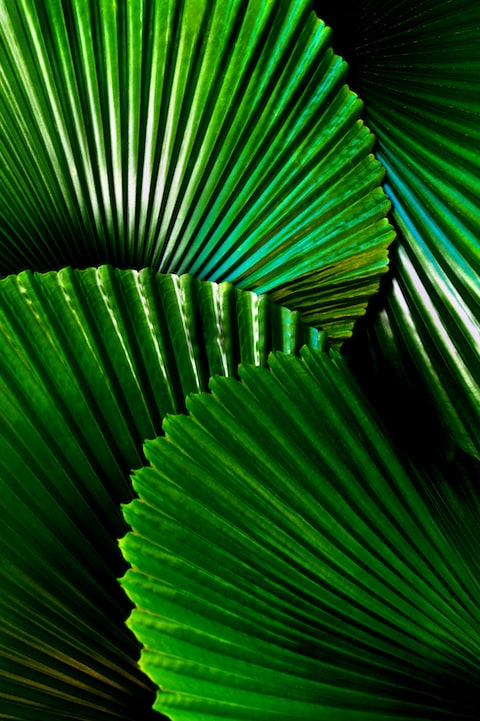

Similar Image Search Results


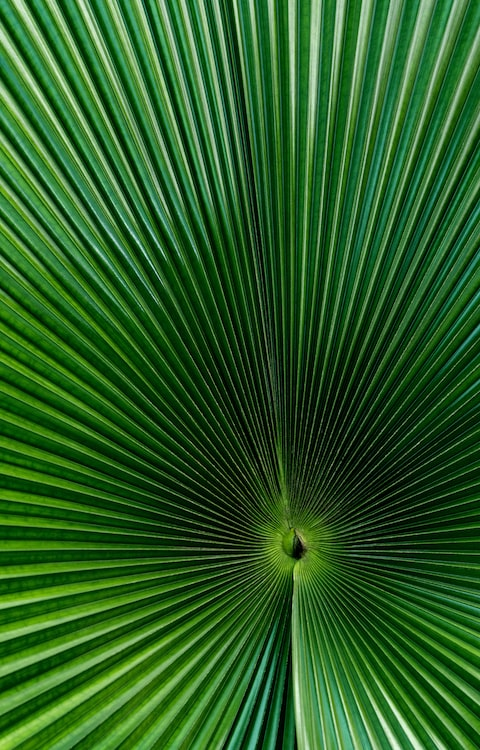

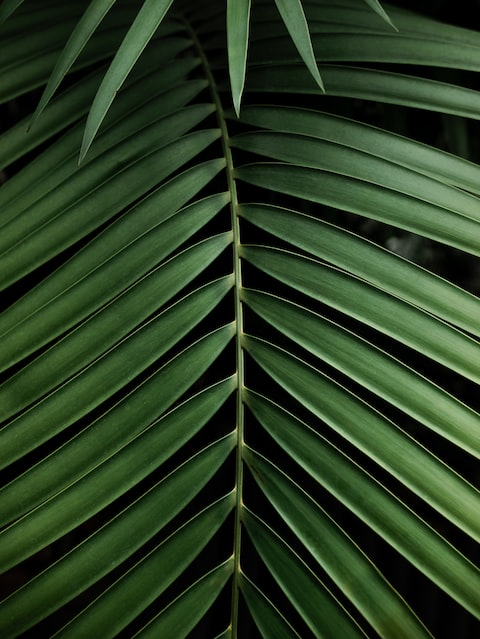

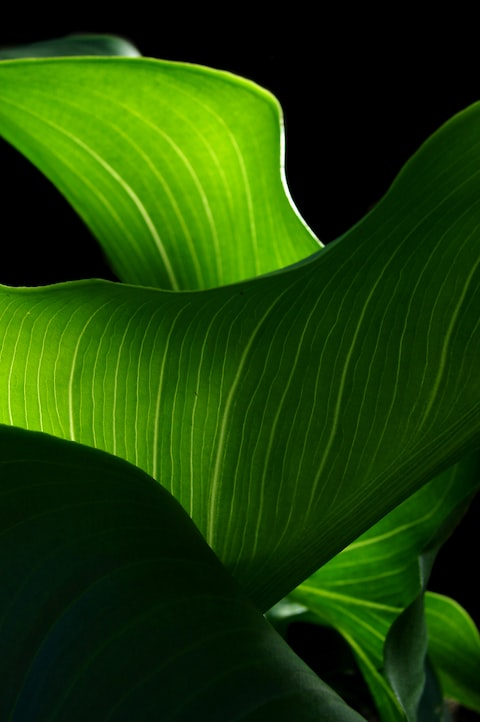

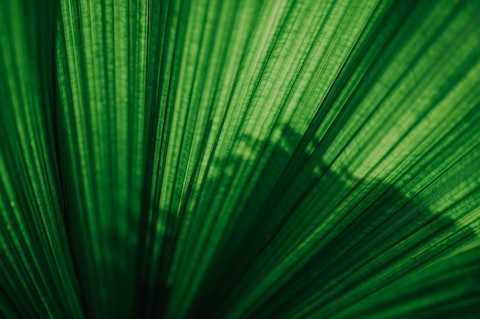

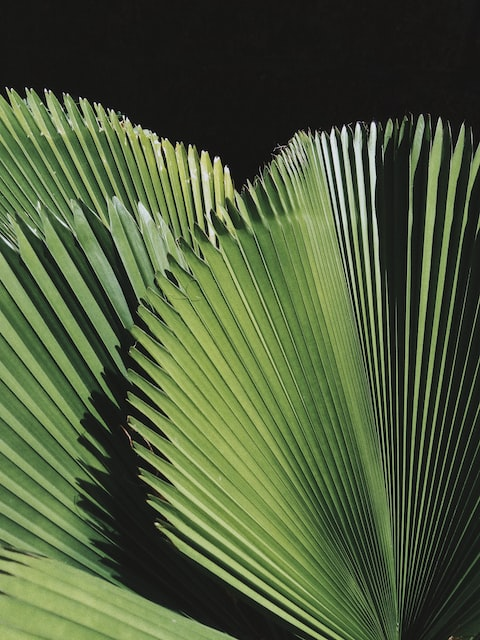

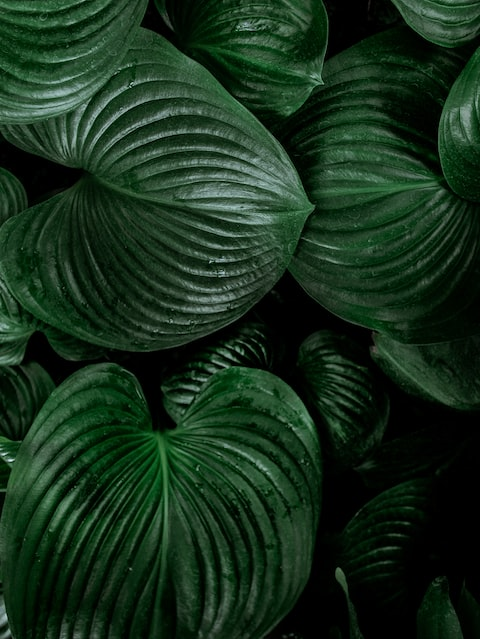

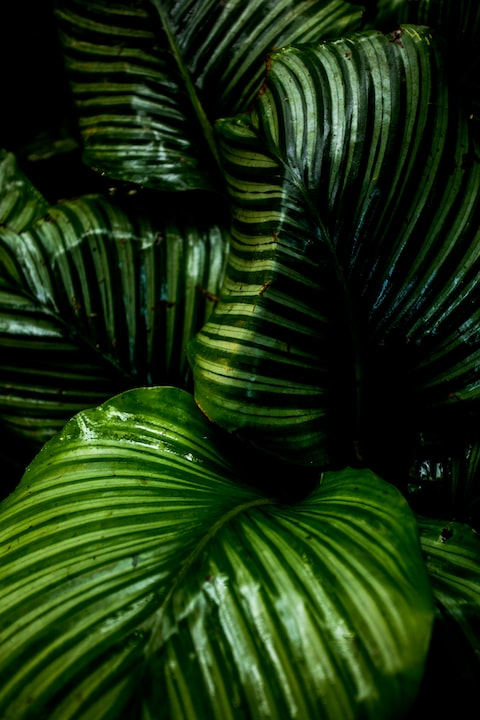

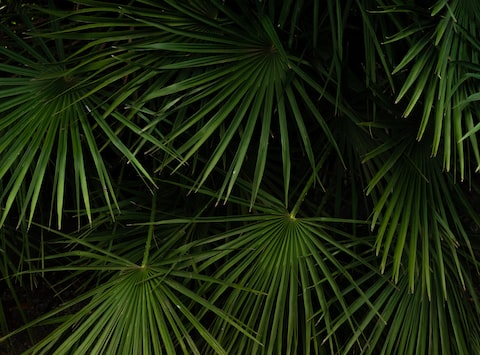

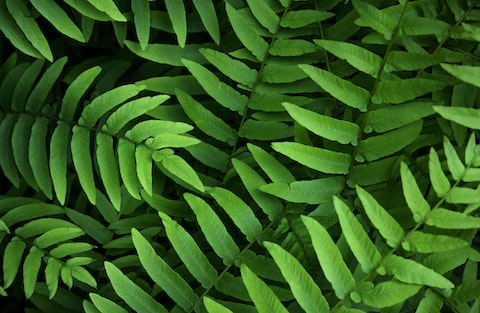

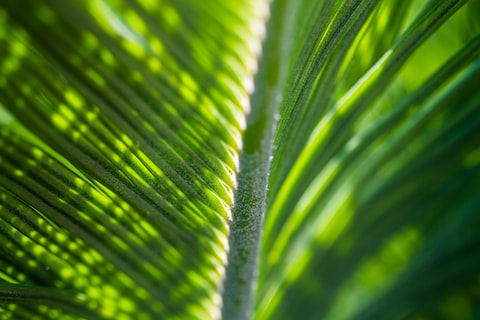

In [ ]:
## Sample queries to try
## Query 1: Image having leaves

image_path = photos_dir / 'PteQb2-8rmY.jpg'
print("QUERY IMAGE WITH LEAVES")
display(DisplayImage(image_path))

query_image = load_image_from_url(image_path)
query_repr = image_feature_extractor.get_image_features(images=[query_image])[0]
(similarities, sim_images) = image_indexer.search_index(np.array([query_repr]))

print("Similar Image Search Results")
for img in sim_images[0][1:]:
  #print(image_names[img])
  display(DisplayImage(photos_dir / image_names[img]))




QUERY IMAGE WITH MOUNTAINS


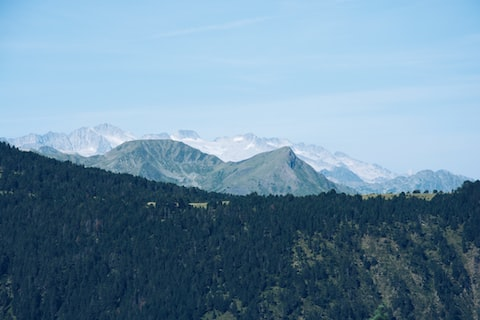

Similar Image Search Results


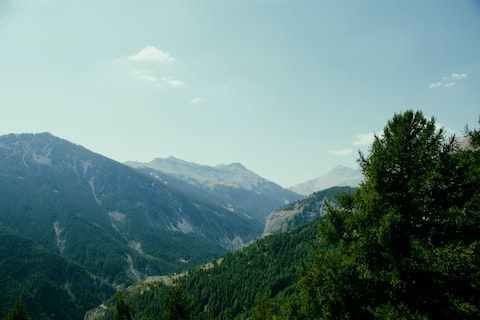

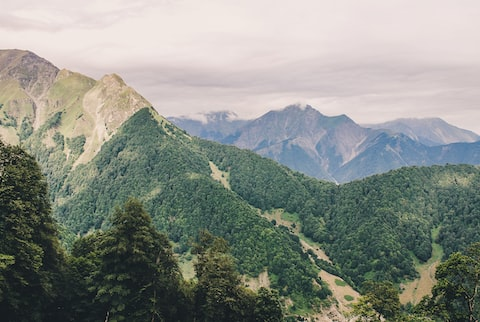

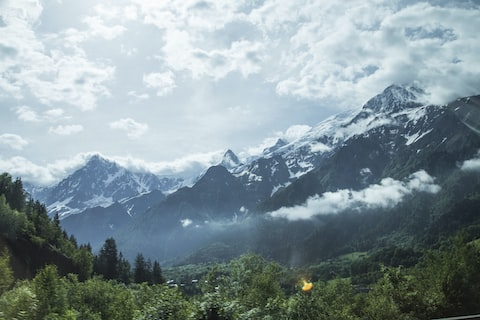

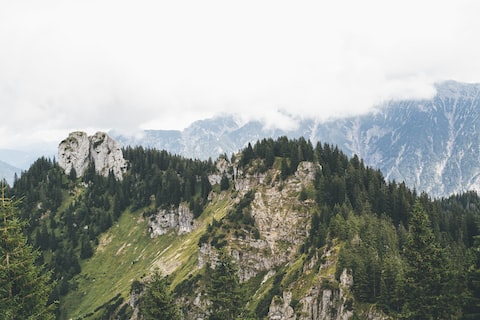

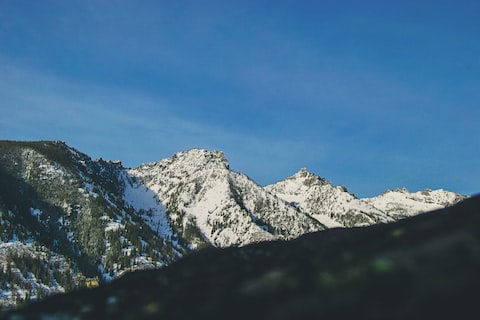

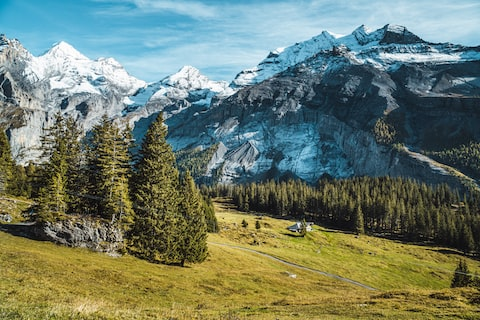

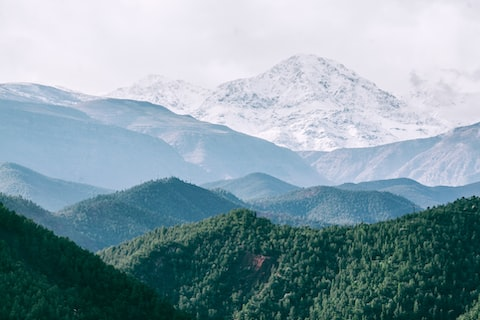

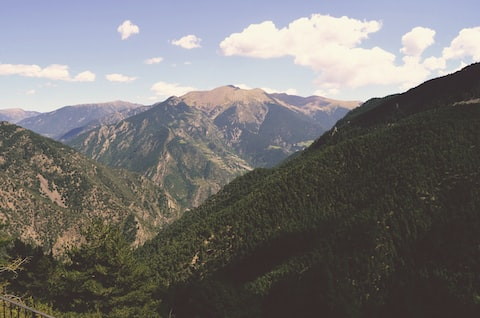

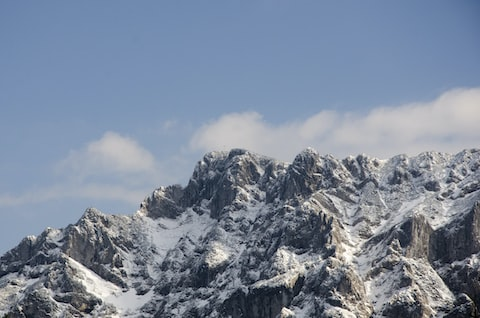

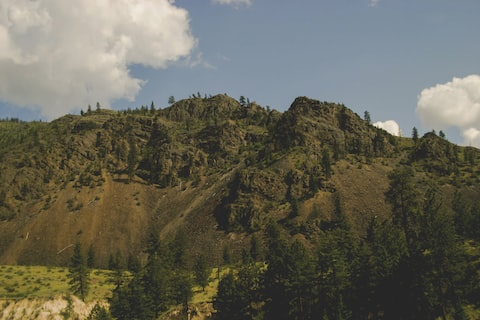

In [ ]:
image_path = photos_dir / 'PUHqjv88Rxw.jpg'

print("QUERY IMAGE WITH MOUNTAINS")
display(DisplayImage(image_path))

query_image = load_image_from_url(image_path)
query_repr = image_feature_extractor.get_image_features(images=[query_image])[0]
(similarities, sim_images) = image_indexer.search_index(np.array([query_repr]))

print("Similar Image Search Results")
for img in sim_images[0][1:]:
  #print(image_names[img])
  display(DisplayImage(photos_dir / image_names[img]))




QUERY IMAGE WITH STRINGS/FIBRE


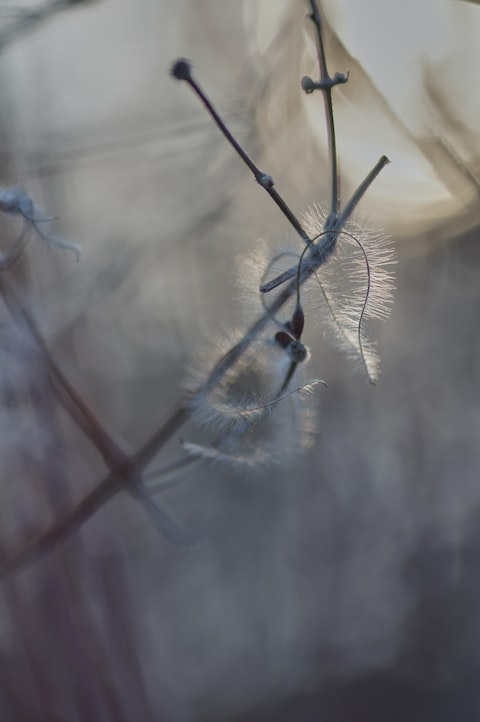

Similar Image Search Results


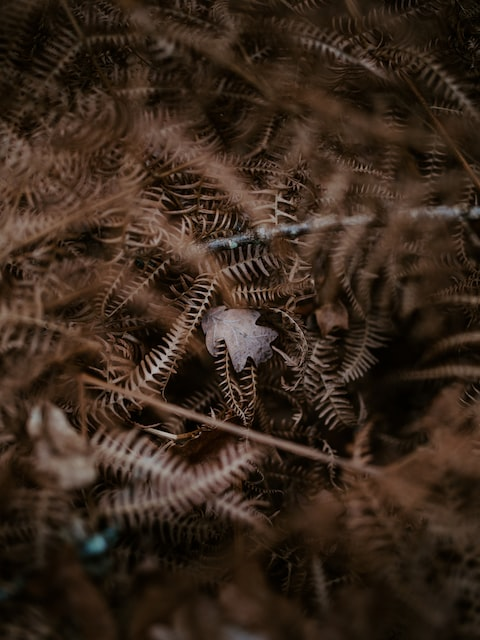

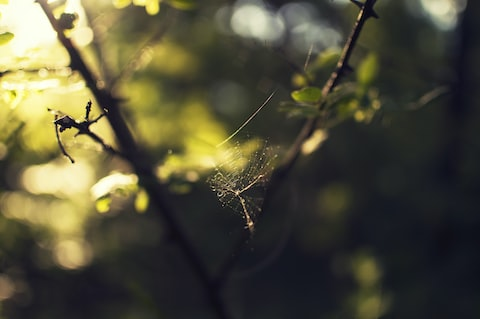

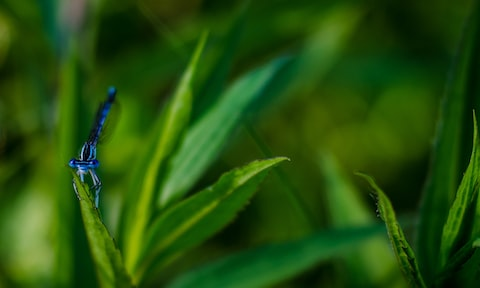

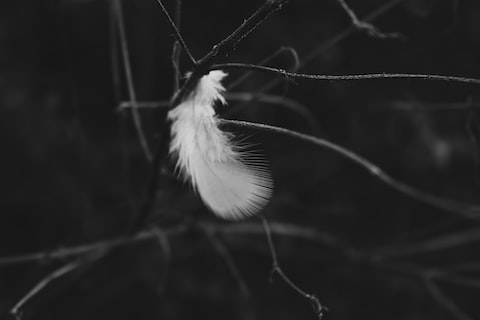

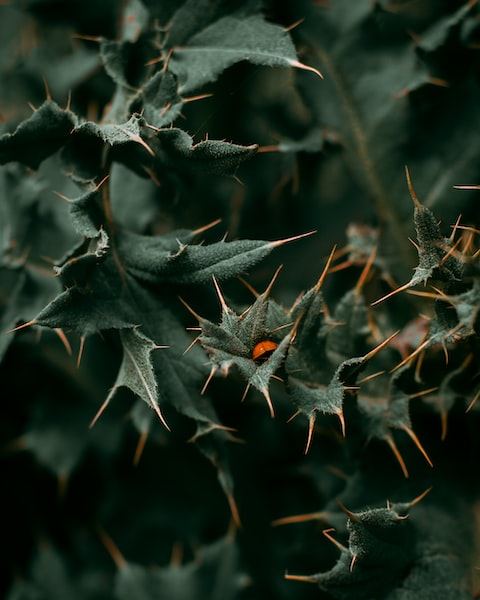

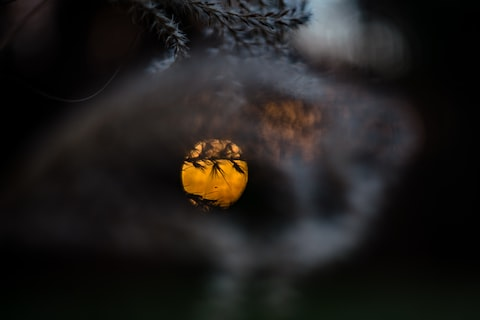

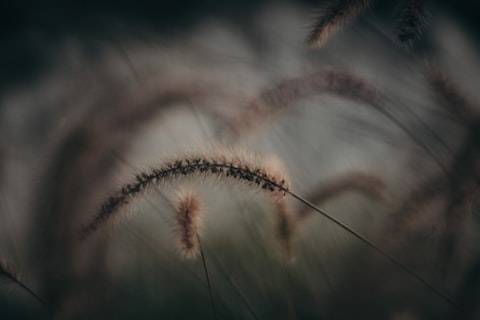

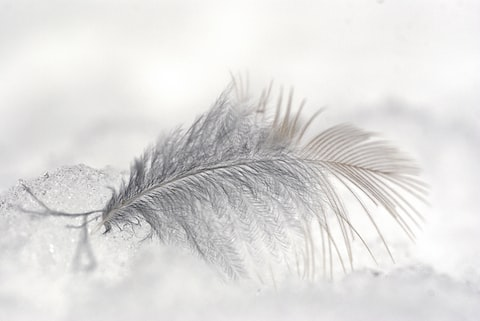

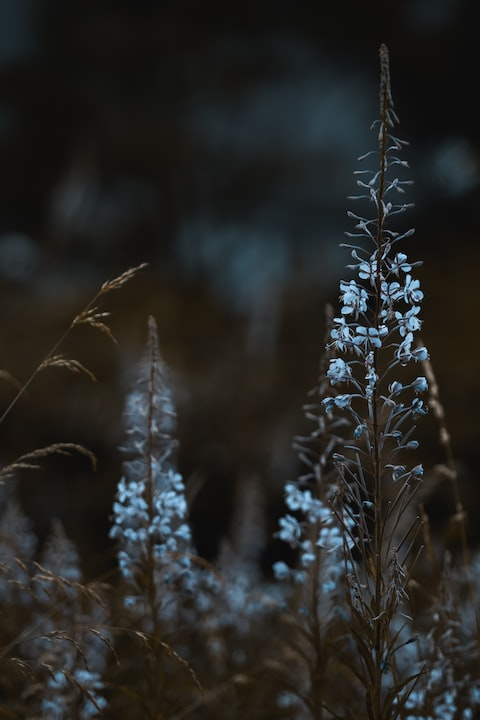

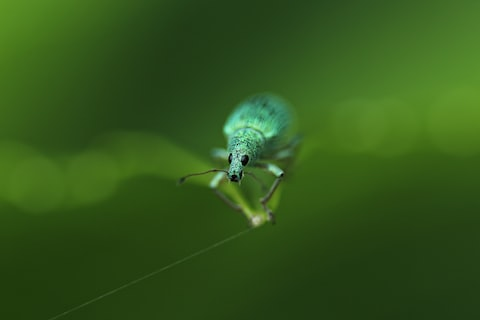

In [ ]:
image_path = photos_dir / 'PJlnMW-m5u4.jpg'
print("QUERY IMAGE WITH STRINGS/FIBRE")
display(DisplayImage(image_path))

query_image = load_image_from_url(image_path)
query_repr = image_feature_extractor.get_image_features(images=[query_image])[0]
(similarities, sim_images) = image_indexer.search_index(np.array([query_repr]))

print("Similar Image Search Results")
for img in sim_images[0][1:]:
  #print(image_names[img])
  display(DisplayImage(photos_dir / image_names[img]))

QUERY IMAGE WITH MERMAID ACRYLIC ART


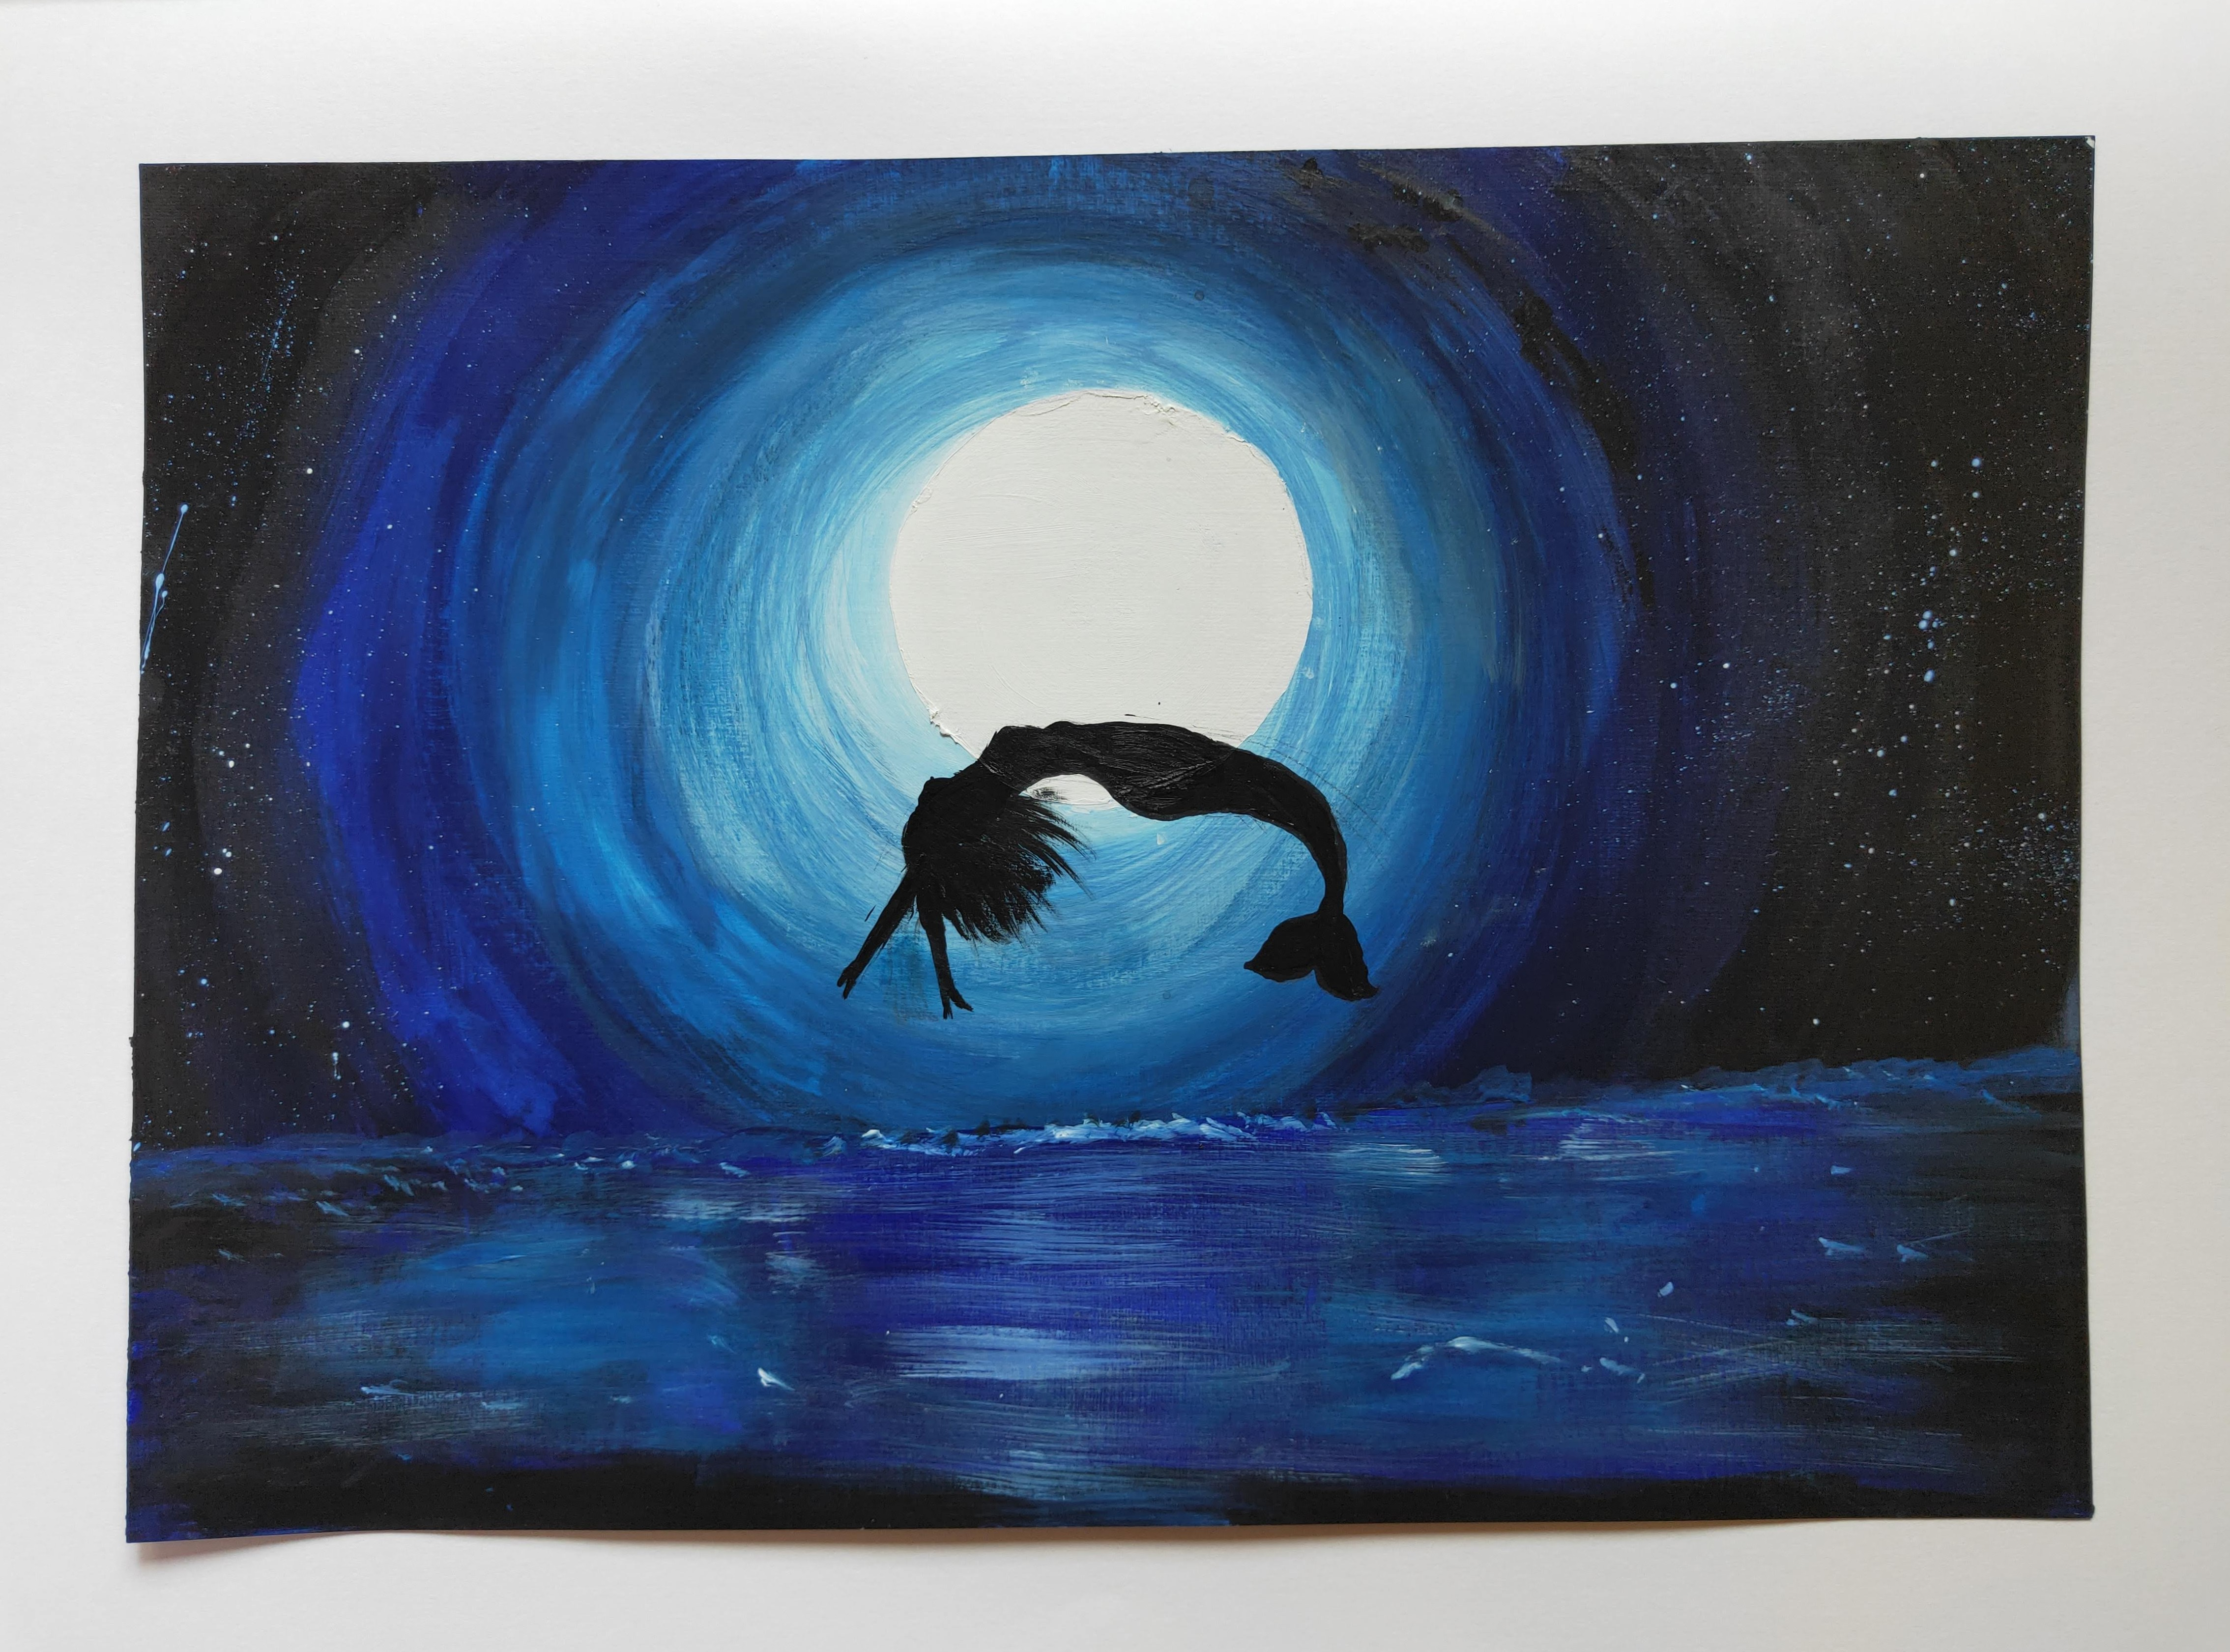

Similar Image Search Results


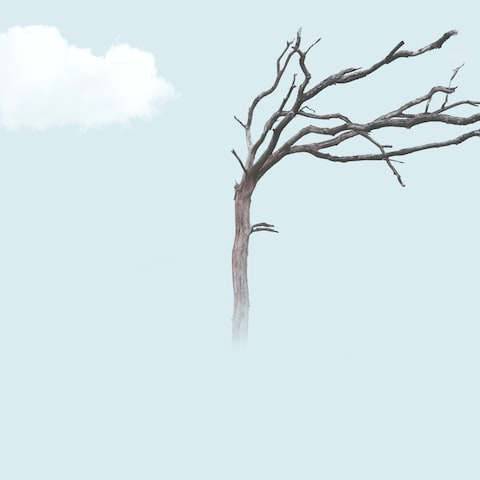

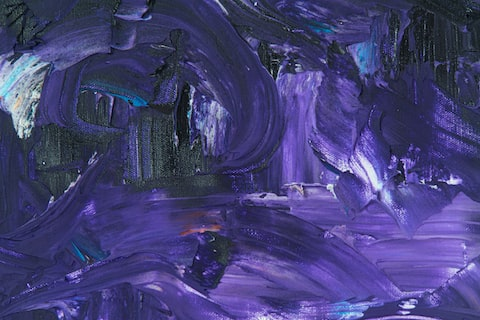

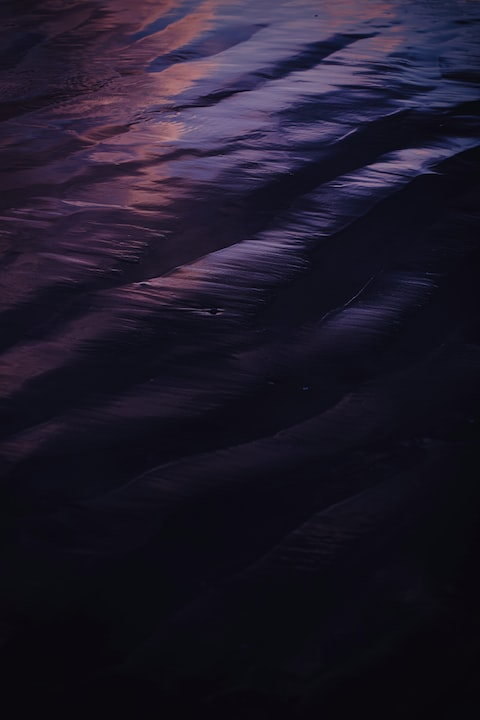

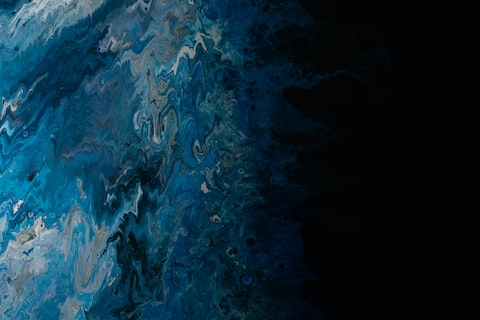

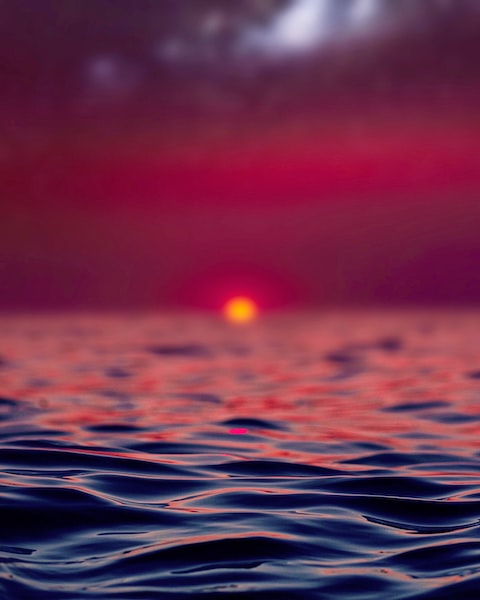

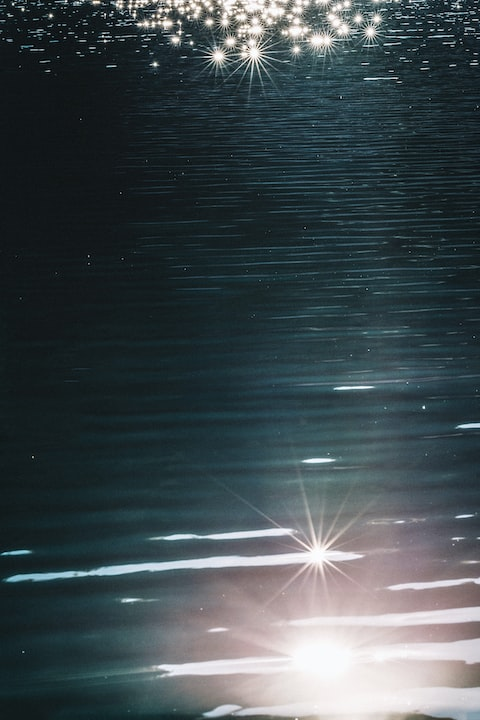

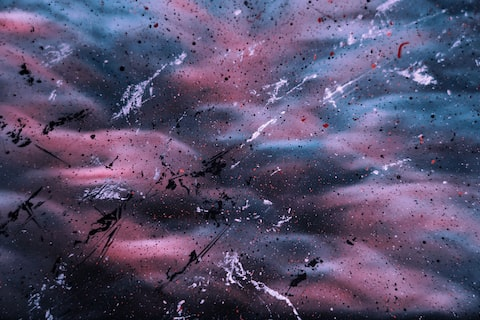

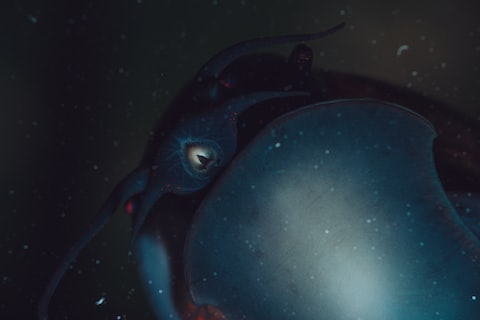

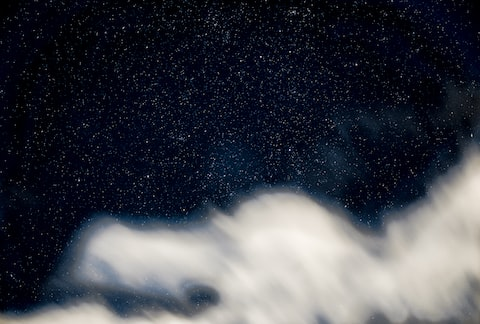

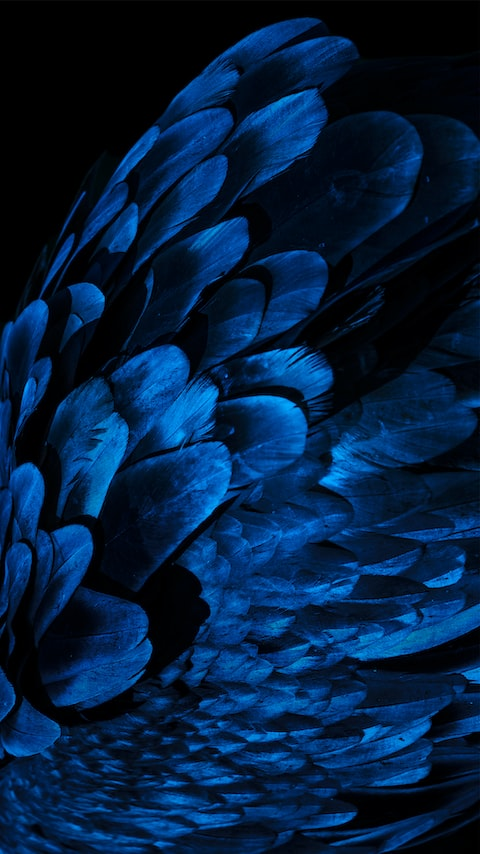

In [ ]:
image_path = Path(root_dir) / 'mermaid.jpg'
print("QUERY IMAGE WITH MERMAID ACRYLIC ART")
display(DisplayImage(image_path))

query_image = load_image_from_url(image_path)
query_repr = image_feature_extractor.get_image_features(images=[query_image])[0]
(similarities, sim_images) = image_indexer.search_index(np.array([query_repr]))

print("Similar Image Search Results")
for img in sim_images[0][1:]:
  #print(image_names[img])
  display(DisplayImage(photos_dir / image_names[img]))

**Conclusions**

The similar search results for the query images tried, the results look aligned with expectations. In fact, the last query is an image outside of the corpus and the results appeared quite similar to what the query image is. Some final stats:
1. Total number of images for this assignment: 14,365
2. Final FAISS index size: ~28MB

**Next steps and future work**

1. Try out another image dataset or add more challenging images:
Imagenet adversarial: https://github.com/hendrycks/natural-adv-examples

2. Invest in evaluation framework. This in itself helps in healthy testing of the search pipeline as well.

3. May be can invest some time in test-cases.

4. Most importantly, understand the operation of the CLIP model and see what hyper-parameters can be set well to ensure searching works better.

5. In the indexing pipeline, a good batch implementation will speed up the indexing process

6. Based on the nature of updates the image corpus will go through, the indexing library or framework will be a very important decision. If the corpus keeps getting changed very frequently, we will have to revisit the indexing library decision. 

7. CLIP model also works with text inputs, it will be interesting to see how we can leverage this additional context to better search results.

Thank you! Hope this helps!